In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# dataset load
data = pd.read_csv("/home/dataset/complete_dataset.csv")
data_only_pm25 = pd.DataFrame(data.loc[:, ["PM-2.5", "일시"]])
data_only_pm25["일시"] = pd.to_datetime(data_only_pm25["일시"])
data_only_pm25.index = data_only_pm25["일시"]
del data_only_pm25["일시"]
data_only_pm25.info()
data = data_only_pm25

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1979 entries, 2018-04-01 to 2023-08-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PM-2.5  1979 non-null   float64
dtypes: float64(1)
memory usage: 30.9 KB


In [3]:
class PatchTSDataset(torch.utils.data.Dataset):
  def __init__(self, ts:np.array, patch_length:int=16, n_patches:int=6, prediction_length:int=4):
    self.P = patch_length
    self.N = n_patches
    self.L = int(patch_length * n_patches / 2)  # look-back window length
    self.T = prediction_length
    self.data = ts

  def __len__(self):
    return len(self.data) - self.L - self.T + 1

  def __getitem__(self, i):
    look_back = self.data[i:(i+self.L)]
    look_back = np.concatenate([look_back, look_back[-1]*np.ones(int(self.P / 2), dtype=np.float32)])
    x = np.array([look_back[i*int(self.P/2):(i+2)*int(self.P/2)] for i in range(self.N)])
    y = self.data[(i+self.L):(i+self.L+self.T)]
    return x, y

In [4]:
from sklearn.preprocessing import MinMaxScaler

tst_size = 200
patch_length = 16 # 16으로 고정
n_patches = 8 # 64나 96을 사용
# patch_length는 고정, n_patches를 32의 배수로 계속 바꿔가면서 실험
# 데이터셋이 작은 경우 n_patches = 24,48, .. 클 경우 96, 192...
# 저자들이 주장하는 최적의 n_patches = 42, 64
prediction_length = 4
window_size = int(patch_length * n_patches / 2)

scaler = MinMaxScaler()
trn_scaled = scaler.fit_transform(data[:-tst_size].to_numpy(dtype=np.float32)).flatten()
tst_scaled = scaler.transform(data[-tst_size-window_size:].to_numpy(dtype=np.float32)).flatten()

trn_ds = PatchTSDataset(trn_scaled, patch_length, n_patches)
tst_ds = PatchTSDataset(tst_scaled, patch_length, n_patches)

trn_dl = torch.utils.data.DataLoader(trn_ds, batch_size=32, shuffle=True)
tst_dl = torch.utils.data.DataLoader(tst_ds, batch_size=tst_size, shuffle=False)

In [5]:
class PatchTST(nn.Module):
  def __init__(self, n_token, input_dim, model_dim, num_heads, num_layers, output_dim):
    super(PatchTST, self).__init__()
    self.patch_embedding = nn.Linear(input_dim, model_dim)    # Input Embedding
    self._pos = torch.nn.Parameter(torch.randn(1,1,model_dim))  # Positional Embedding

    encoder_layers = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, batch_first=True)
    self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

    self.output_layer = nn.Linear(model_dim * n_token, output_dim)

  def forward(self, x):
    # x shape: (batch_size, n_token, token_size)
    x = self.patch_embedding(x)   # (batch_size, n_token, model_dim)
    x = x + self._pos
    x = self.transformer_encoder(x)   # (batch_size, n_token, model_dim)
    x = x.view(x.size(0), -1)       # (batch_size, n_token * model_dim)
    output = self.output_layer(x)   # (batch_size, out_dim =4 patch_size == 4)
    return F.sigmoid(output)

In [6]:
from tqdm.auto import trange
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = PatchTST(n_patches, patch_length, 128, 8, 4, prediction_length)
model.to(device)

optim = torch.optim.AdamW(model.parameters(), lr=0.0001)

pbar = trange(100)
for _ in pbar:
  model.train()
  trn_loss = 0.
  for x,y in trn_dl:
    x, y = x.to(device), y.to(device)
    p = model(x)
    optim.zero_grad()
    loss = F.mse_loss(p, y)
    loss.backward()
    optim.step()
    trn_loss += loss.item()*len(x)
  trn_loss = trn_loss / len(trn_ds)

  model.eval()
  with torch.inference_mode():
    x, y = next(iter(tst_dl))
    x, y = x.to(device), y.to(device)
    p = model(x)
    tst_loss = F.mse_loss(p,y)
  pbar.set_postfix({'loss':trn_loss, 'tst_loss':tst_loss.item()})

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

: 

In [13]:
def mape(y_pred, y_true):
  return (np.abs(y_pred - y_true)/y_true).mean() * 100

def mae(y_pred, y_true):
  return np.abs(y_pred - y_true).mean()

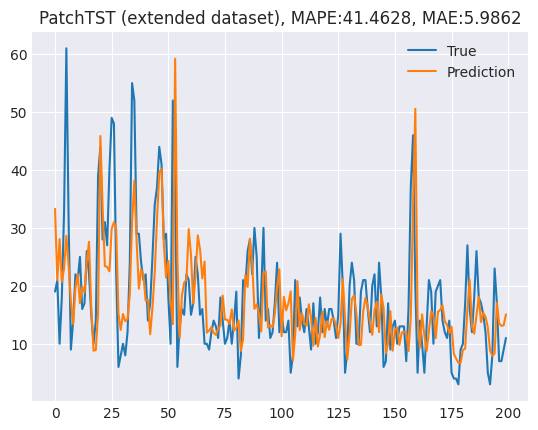

In [14]:
model.eval()
with torch.inference_mode():
  x, y = next(iter(tst_dl))
  x, y = x.to(device), y.to(device)
  p = model(x)

y = scaler.inverse_transform(y.cpu())
p = scaler.inverse_transform(p.cpu())

y = np.concatenate([y[:,0], y[-1,1:]])
p = np.concatenate([p[:,0], p[-1,1:]])

plt.title(f"PatchTST (extended dataset), MAPE:{mape(p,y):.4f}, MAE:{mae(p,y):.4f}")
plt.plot(range(tst_size), y, label="True")
plt.plot(range(tst_size), p, label="Prediction")
plt.legend()
plt.show()

# res_dict.update({'PatchTST/8': {'MAPE':mape(p,y), 'MAE':mae(p,y)}})

In [ ]:
# prediction window size를 키우거나
# dynamic 방식으로 예측을 이어나가는 형식으로도 확인해볼 것